In [8]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, div.text_cell_render ol li p, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

In [2]:
import warnings
import os
import logging
# 경고 제거
warnings.filterwarnings('ignore')

# transformers 로깅 레벨 조정
logging.getLogger("transformers").setLevel(logging.ERROR)

# Hugging Face symlink 경고 제거
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# from transformers import pipeline, logging as hf_logging
# hf_logging.set_verbosity_error()

# <span style="color:red">ch1. 허깅페이스</span>
- Inference API 이용 : 모델의 결과를 server에서
- pipeline() 이용 : 모델을 다운로드 받아 모델의 결과를 local에서
    * raw text -> tokenizer -> model -> [0.11, 0.55, 0.xx, ~] logits값으로 prediction결과 출력
```
허깅페이스 transformers에서 지원하는 task
"sentiment-analysis" : "text-classification"의 별칭(감정분석 전용으로 사용)
"text-classification" : 감정분석, 뉴스분류, 리뷰분류 등 일반적인 문장 분류
"zero-shot-classification" : 레이블을 학습 없이 주어진 후보군 중에서 분류
"token-classification" : 개체명 인식(NER ; Named Entity Recognition) 등 단위 라벨링
"ner" : "token-classification"의 별칭
"fill-mask" : 빈칸 채우기
"text-generation" : 텍스트 생성 (GPT류 모델에 사용)
"text2text-generation" : 번역, 요약, 등 입력 -> 출력 변환
"translation" : 번역
"summarization" : 텍스트 요약
"question-answering" : 주어진 context를 보고 질문에 답하기
"image-to-text" : 그림을 설명
"image-classification" : 이미지 분류
```

##  1. 텍스트 기반 감정분석(긍정/부정)
- c:/사용자/내컴퓨터명/.cache/huggingface/hub 모델 다운로드

In [3]:
from transformers import pipeline
classifier = pipeline(task="sentiment-analysis")
classifier("I've been waiting for a HuggingFace course my whole life.")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9598049521446228}]

In [4]:
classifier = pipeline(task="text-classification",
                      model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")
# 감정 분석시 내용이 많으면 list로
classifier([
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much"
])

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9995144605636597}]

In [5]:
classifier(["이 영화 정말 최고였어요. 감동적이고 연기가 대단해",
           "This movie was the best. It's touching, and the acting is amazing"])

[{'label': 'POSITIVE', 'score': 0.857815682888031},
 {'label': 'POSITIVE', 'score': 0.9998821020126343}]

In [6]:
classifier("이 물건 사고 싶어요")

[{'label': 'POSITIVE', 'score': 0.8786237239837646}]

In [7]:
classifier = pipeline(task="sentiment-analysis",
                     model="matthewburke/korean_sentiment")
texts = ["나는 너가 좋아", "당신이 싫어요", "힘들어요", "오늘 기분이 최고야"]
result = classifier(texts)

Device set to use cpu


In [8]:
for text, result in  zip(texts, classifier(texts)):
    label = "긍정" if result['label']=='LABEL_1' else "부정"
    print(f"{text} => {label} : {result['score']:.4f}")

나는 너가 좋아 => 긍정 : 0.9558
당신이 싫어요 => 부정 : 0.9093
힘들어요 => 부정 : 0.9140
오늘 기분이 최고야 => 긍정 : 0.9714


## 2. 제로샷분류(Zero-shot분류)
- 기계학습 및 자연어처리에서 각 개별 작업에 대한 특정 교육 없이 작업을 수행할 수 있는 모형(비지도 학습)

In [9]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")
classifier(
    "I have a problem with my phone that needs to be resolved asap!",
    candidate_labels=["urgent", "not urgent", "phone", "tablet", "computer"]
)

Device set to use cpu


{'sequence': 'I have a problem with my phone that needs to be resolved asap!',
 'labels': ['urgent', 'phone', 'not urgent', 'computer', 'tablet'],
 'scores': [0.6228813529014587,
  0.37086236476898193,
  0.0029875338077545166,
  0.001735040219500661,
  0.0015337676741182804]}

In [10]:
sequence_to_classify = "one day I will see the world"
candidate_labels = ['travel', 'cooking', 'dancing']
classifier(sequence_to_classify, candidate_labels)

{'sequence': 'one day I will see the world',
 'labels': ['travel', 'dancing', 'cooking'],
 'scores': [0.9938651919364929, 0.0032737581059336662, 0.0028610501904040575]}

## 3. text 생성

In [11]:
from transformers import pipeline, set_seed
set_seed(2)
generation = pipeline("text-generation", "gpt2") # 텍스트 생성 gpt3부터는 허깅페이스없음
generation(
    "in this course. We will teach you how to",
    pad_token_id = generation.tokenizer.eos_token_id
) # pad_token_id 경고를 없애려고 setting

Device set to use cpu


[{'generated_text': 'in this course. We will teach you how to build your own tools to solve your own problems. We will teach you how to create code that works for you. We will teach you how to use a project manager to manage your project with ease. We will teach you how to build new tools to solve problems for you. We will teach you how to use a project manager to manage your project with ease. We will teach you how to use a project manager to manage your project with ease. We will teach you how to use a project manager to manage your project with ease.\n\n\nWe will teach you how to build your own tools to solve your own problems. We will teach you how to use a project manager to manage your project with ease. We will teach you how to use a project manager to manage your project with ease. We will teach you how to build your own tools to solve your own problems. We will teach you how to use a project manager to manage your project with ease. We will teach you how to use a project manag

In [12]:
result = generation(
    "in this course. We will teach you how to",
    pad_token_id = generation.tokenizer.eos_token_id
)
print(result[0]['generated_text'])

in this course. We will teach you how to create virtual objects, how to use virtual controllers to implement your application, and how to create classes, functions, and properties. We will cover the basics of creating virtual objects, how to create virtual controllers, and how to use virtual services. We'll discuss the fundamentals of virtual objects and how to use services to create virtual objects. We'll also cover the various ways to use virtual services to create virtual objects and how to use virtual services. We'll discuss the concepts of virtual methods, virtual objects, and virtual virtual functions. We'll also learn how to use virtual functions to create virtual functions and how to use virtual services. We'll also learn how to use virtual functions with virtual objects. And we'll get you started on this course!

Virtual Objects

In this course, we'll learn how to create virtual objects, how to use virtual controllers, how to use virtual services, and how to use virtual servic

In [15]:
generation = pipeline("text-generation", "skt/kogpt2-base-v2")
result = generation("이 과정은 다음과 같은 방법을 알려드려요. ",
                    pad_token_id = generation.tokenizer.eos_token_id,
                    max_new_tokens = 100, # 생성할 최대 길이(생성할 토큰 수)
                    # num_return_sequence=1, # 생성할 문장 갯수
                    do_sample=True,        # 다양한 샘플 사용
                    top_k=50,           # top_k 샘플링(확률 높은 상위 50개 토큰만 사용)
                    top_p=0.95,         # 확률이 높은 순서대로 95%가 될 때까지의 단어들로만 후보 사용
                    temperature=1.2,    # 창의성 조절(낮을수록 보수적)
                    no_repeat_ngram_size=2 # 반복 방지
                   )
print(result[0]['generated_text'])

Device set to use cpu


이 과정은 다음과 같은 방법을 알려드려요. 뭔가 좀 더 좋은 일이 있길래 그냥 집에 가서 일하시거든요? 저는 일단 요리를 하게 됩니다. 그러면 그거를 먹을 때도 제가 맛을 좀 보시잖아요. 그렇게 하면 어떨 것 같아요. 어~ 햄을 조금 먹으면 좀 맵습니다. 땡겨져 있는 요리가 훨씬 더 맛있을 거 같아요 뭘."
'안 돼! 정말 못하겠다. 안 돼. 그런 것 같아서 너무 심란해서 그래? 아니면 정말 너무 먹으라


# 4. 마스크(빈칸) 채우기 

In [4]:
unmasker = pipeline(task='fill-mask',
                    model='distilbert/distilroberta-base') # 마스크 채우기
unmasker("I'm going to hospital and meet a <mask>", top_k=2) # top_k 기본값 5

Some weights of the model checkpoint at distilbert/distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'score': 0.19275707006454468,
  'token': 3299,
  'token_str': ' doctor',
  'sequence': "I'm going to hospital and meet a doctor"},
 {'score': 0.06794589757919312,
  'token': 27321,
  'token_str': ' psychiatrist',
  'sequence': "I'm going to hospital and meet a psychiatrist"}]

In [22]:
# unmasker("병원에 가서 <mask>를 만날 거에요")

In [5]:
unmasker("Hello, I'm a <mask> model.")

[{'score': 0.0629730075597763,
  'token': 265,
  'token_str': ' business',
  'sequence': "Hello, I'm a business model."},
 {'score': 0.038101598620414734,
  'token': 18150,
  'token_str': ' freelance',
  'sequence': "Hello, I'm a freelance model."},
 {'score': 0.03764132782816887,
  'token': 774,
  'token_str': ' role',
  'sequence': "Hello, I'm a role model."},
 {'score': 0.037326786667108536,
  'token': 2734,
  'token_str': ' fashion',
  'sequence': "Hello, I'm a fashion model."},
 {'score': 0.026023676618933678,
  'token': 24526,
  'token_str': ' Playboy',
  'sequence': "Hello, I'm a Playboy model."}]

In [6]:
unmasker = pipeline(task="fill-mask",
                    model="google-bert/bert-base-uncased")
unmasker("Hello, I'm a [MASK] model.")

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'score': 0.1441437155008316,
  'token': 2535,
  'token_str': 'role',
  'sequence': "hello, i ' m a role model."},
 {'score': 0.14175789058208466,
  'token': 4827,
  'token_str': 'fashion',
  'sequence': "hello, i ' m a fashion model."},
 {'score': 0.062214579433202744,
  'token': 2047,
  'token_str': 'new',
  'sequence': "hello, i ' m a new model."},
 {'score': 0.041028350591659546,
  'token': 3565,
  'token_str': 'super',
  'sequence': "hello, i ' m a super model."},
 {'score': 0.025911200791597366,
  'token': 2449,
  'token_str': 'business',
  'sequence': "hello, i ' m a business model."}]

### ※ InferenceAPI 사용

In [7]:
from dotenv import load_dotenv
import os
load_dotenv()
# os.environ['HF_TOKEN']
# 허깅페이스 토큰을 READ권한으로 생성하여 .env에 추가 (.git ignore파일 추가)

True

In [10]:
# unmasker = pipeline(task="fill-mask",
#                     model="google-bert/bert-base-uncased")
# unmasker("Hello, I'm a [MASK] model.")
from dotenv import load_dotenv
import os
load_dotenv()
from huggingface_hub import InferenceClient
client = InferenceClient(
            provider="hf-inference",
            api_key=os.environ['HF_TOKEN'], # 허깅페이스 토큰 키
)
result = client.fill_mask(
    "Hello, I'm a [MASK] model.",
     model="google-bert/bert-base-uncased",
     top_k=2 #기본 5개
)
result

[FillMaskOutputElement(score=0.1441427320241928, sequence="hello, i ' m a role model.", token=2535, token_str='role', fill_mask_output_token_str=None),
 FillMaskOutputElement(score=0.14175812900066376, sequence="hello, i ' m a fashion model.", token=4827, token_str='fashion', fill_mask_output_token_str=None)]

In [12]:
[f'{r.sequence} ({r.score:.2%})' for r in result]

["hello, i ' m a role model. (14.41%)",
 "hello, i ' m a fashion model. (14.18%)"]

## 5. 개체명 인식(NER : Named Entity Recognition)

In [14]:
ner = pipeline(task="ner",
               model="dbmdz/bert-large-cased-finetuned-conll03-english",
               grouped_entities=True) # 개체들을 그룹으로 묶을지 말지
ner("My name is Sylvain and I work at Hugging Face in Brooklyn.")
# Sylvain : 사람(PER)
# Hugging Face : 조직(ORG)
# Brooklyn : 장소(LOC)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'entity_group': 'PER',
  'score': 0.9981694,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9796019,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.9932106,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

## 6. 질의 응답

In [13]:
from transformers import pipeline
question_answerer = pipeline("question-answering",
                            "distilbert/distilbert-base-cased-distilled-squad") # 질의응답
question_answerer(
    question="Where do I work?",
    context = "My name is Sylvain and I work at Hugging Face in Brooklyn."
) # 지문(context)을 이용해서 답하기

Device set to use cpu


{'score': 0.6385911703109741, 'start': 33, 'end': 45, 'answer': 'Hugging Face'}

In [10]:
context = "My name is Sylvain and I work at Hugging Face in Brooklyn."
result = question_answerer(question="Where do I work?", context=context)

In [11]:
result.get('answer'), context[result.get('start') : result.get('end')], result.get('score')

('Hugging Face', 'Hugging Face', 0.6385911703109741)

## 7. 문서요약
- 현재 torch 버전이 2.6이하이면 Hugging Face에서 강제로 막고 있음

In [17]:
summarizer = pipeline(task='summarization',
                      model='sshleifer/distilbart-cnn-12-6')
summarizer(
    """
    Coupang was stolen too...The Personal Information Commission is far short of investigators
31 survey workers for the fourth year...'I haven't even received due diligence for months after reporting.'
The Personal Information Commission said, 'We are discussing the increase of staff...Most of them will be put into the research sector'
'As soon as we were aware of the hacking, we immediately reported it to the relevant agencies, but some companies haven't even received due diligence yet, months later.'
While the strategic value of personal information in the AI era is rapidly increasing, the takeover attacks are becoming more sophisticated, and some companies are waiting months without even setting an investigation schedule even though they reported it immediately after the accident. This year, a series of major accidents including SKT, Lotte Card, and Coupang have revealed structural limitations in which the supervisory authority's investigation capabilities are in place again.
According to the industry on Tuesday, the number of investigators dedicated to infringement by the Personal Information Protection Committee has remained at 31 from 2022 until this year. When a major accident occurs, more than 10 people are put into a single case, and in this case, other investigation schedules are delayed by several months. Some companies have reportedly not even received due diligence for nearly a year after reporting.
An official from the Personal Information Commission explained, 'If a limited workforce is concentrated on a large case, the schedule of other cases will inevitably be delayed.'
The problem is that the purpose and method of attack are becoming more advanced as hacking targets are expanded to customer data that can be used to learn AI models. In the case of Coupang, behavioral data such as customer order details were included in the leak, and in the case of financial companies and telecommunication companies, there is a growing concern about subsequent damage due to external exposure of customer information.
Investigation of infringement incidents leads to on-site forensics, server/DB inspection, log analysis, technology verification, and administrative disposition review, and it is pointed out that bottlenecks are constantly occurring as a small group of investigators carry out all procedures.
An industry official said, 'Recent infringement attempts have gone beyond simple personal information theft to target AI model learning data,' adding, 'The number of accidents is increasing, but the burden on companies to respond is inevitably increased as the waiting time for investigation to begin.'
Major European Personal Information Supervision Organization, 2 to 6 times that of South Korea
    """,
    max_length=130, # 요약할 내용의 최대 토큰 수
    min_length=30,  # 요약할 내용의 최소 토큰 수
    do_sample=False # 랜덤성이 없음/항상 비슷한 요약
)

Device set to use cpu


[{'summary_text': ' The number of investigators dedicated to infringement by the Personal Information Protection Committee has remained at 31 from 2022 until this year . When a major accident occurs, more than 10 people are put into a single case, and in this case, other investigation schedules are delayed by several months .'}]

## 8. 번역
- pip install sacremoses : 한영번역에서의 경고를 줄이고, 번역품질을 높이기 위해

In [21]:
translator = pipeline(task="translation",
                      model='Helsinki-NLP/opus-mt-fr-en')
# 프랑스어 -> 영어 헬싱키NLP는 다양한 언어 지원

config.json: 0.00B [00:00, ?B/s]

C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--Helsinki-NLP--opus-mt-fr-en. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [23]:
result = translator("ce cours est produit par Huging Face")
result[0]['translation_text']

'this course is produced by Hugging Face'

In [15]:
# 번역하는 모델은 성능이 천차만별. 모델과 라이브러리에 따라 추가 pip 설치
# 한 -> 영
ko2en = pipeline(task="translation", model="Helsinki-NLP/opus-mt-ko-en")

# 영 -> 한(불량)
en2ko = pipeline(task="translation", model="Helsinki-NLP/opus-mt-tc-big-en-ko")

# 테스트 문자
ko_sentence = "이 문장을 영어로 번역해 주세요."
en_sentence = "I enjoy learning about AI."
# 번역수행
print('한->영 : ', ko2en(ko_sentence)[0]['translation_text'])
print('영->한 : ', en2ko(en_sentence)[0]['translation_text'])

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/842k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Device set to use cpu
Device set to use cpu


한->영 :  Please translate this sentence into English.
영->한 :  US  팽창식 줄.


In [16]:
ko2en([
    "내일부터는 langChain 진도 나갑니다",
    "Open Ai API 진도 나갑니다",
    "카드를 지참하셔야합니다"
])

[{'translation_text': "Tomorrow, we're even going to the Langcain camp."},
 {'translation_text': 'Open Ai APls are moving out.'},
 {'translation_text': 'You need to hold on to your cards.'}]

# 10. 이미지를 설명하는 텍스트 생성

In [14]:
image2text = pipeline(task="image-to-text",
                     model="ydshieh/vit-gpt2-coco-en")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/957M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/211 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [17]:
url = "https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png"
image2text(url, max_new_tokens=30) # 최대 30토큰으로 이미지에 대해 설명하는 text

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


[{'generated_text': 'two birds are standing next to each other '}]

<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'numpy.ndarray'>


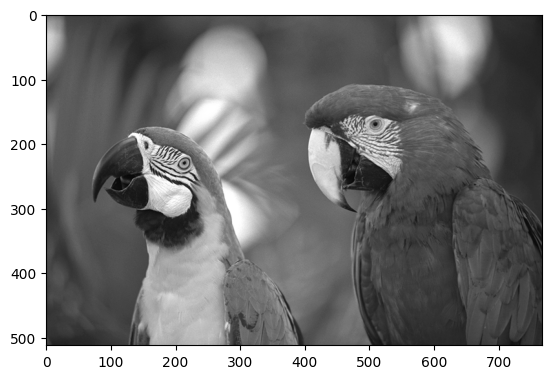

In [19]:
from PIL import Image
import numpy as np
import requests
url = "https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png"
image = Image.open(requests.get(url, stream=True).raw)
print(type(image))
image_numpy = np.array(image)
print(type(image_numpy))
import matplotlib.pyplot as plt
plt.imshow(image_numpy, cmap='gray')

In [20]:
url = "https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png"
image2text(url, max_new_tokens=30) # 최대 30토큰으로 이미지에 대해 설명하는 text

[{'generated_text': 'two birds are standing next to each other '}]

In [21]:

image2text(image)

[{'generated_text': 'two birds are standing next to each other '}]